In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Choosing a Champion: Party Membership and Policy Platform

This paper ([link](https://ideas.repec.org/p/cpr/ceprdp/8941.html)) is about how the existence of parties effects the outcome of elections. They begin with the Hotelling-Downs model of elections. Essentially, we imagine that voters have a preferred policy position, somewhere on a political spectrum, and choose the candidate which is closest to that position. The result is that with 2 parties there is convergence to the median voter. In reality, of course, things are more complicated. People can choose whether or not to vote at all, their utility curves can be complicated (choosing the nearest politician to someones preferred point implies the utility curve is symmetric, concave), the parties themselves don't just care about winning, and voting involves a strong random component. I actually wrote a small notebook trying to flesh out the mechanism is a more first-principles manner ([link](https://colab.research.google.com/drive/1W4SUwGWYfyXJ99cdajYiFLgdHZR_OYVX?usp=sharing)) but nevertheless, the Hotelling-Downs model is a good starting point. Convergence looks something like this:

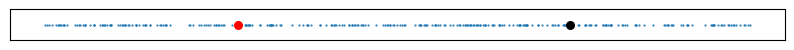

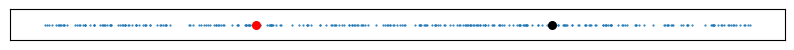

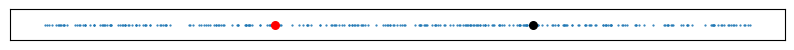

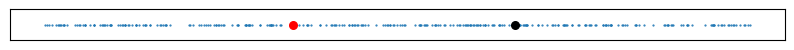

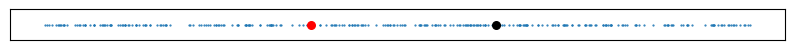

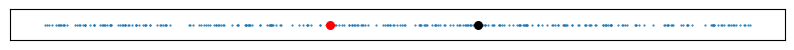

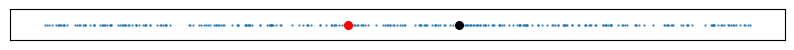

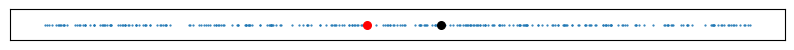

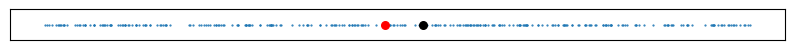

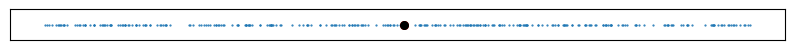

In [73]:
def check_win(party, other_party, prefered_positions):
    d = np.abs(prefered_positions-party)
    d_other = np.abs(prefered_positions-other_party)
    share = np.sum(d<d_other)/len(prefered_positions)
    return share>0.5

def update_party(party, other_party, prefered_positions):
    if not check_win(party, other_party, prefered_positions):
        for step_size in np.logspace(-5, 0, 100):
            if check_win(party+step_size, other_party, prefered_positions):
                return party+step_size, False
            if check_win(party-step_size, other_party, prefered_positions):
                return party-step_size, False
        return party, True
    return party, False

N = 300
prefered_positions = np.random.rand(N)
party1_position = 0.25
party2_position = 0.75
history = []
for epoch in range(1000):
    party1_position, converged1 = update_party(party1_position, party2_position, prefered_positions)
    party2_position, converged2 = update_party(party2_position, party1_position, prefered_positions)
    history.append([party1_position, party2_position])
    if converged1 or converged2:
        break

for p in np.linspace(0, len(history)-1, 10).astype(int):
    plt.figure(figsize=(10,0.4))
    plt.scatter(prefered_positions, np.zeros(N), s=0.3)
    plt.scatter([history[p][0]], [0], color="red", s=30)
    plt.scatter([history[p][1]], [0], color="black", s=30)
    plt.yticks([])
    plt.xticks([])
    plt.show()

In this paper they use a "Contest Success Function", which is just a sigmoid, to describe the probability of the Right (R) party winning over the Left (L), given some advantage $z$. This paper just considers the median voter's utility given the position of both parties and the amount of canvassing they do. I guess this is kindof the same as taking the average utility curve, as I did in the notebook referenced earlier. After some faffing around we basically get $z=s(k_R-k_L + t(d_R - d_L) $, where $k$ is impact of canvassing (what even is cavassing, just a magical impact on the probability of winning then?), $t$ is some scale, and $d$ is the distance. For example, say we have this situation: 

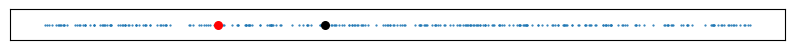

In [118]:
L = 0.25
R = 0.4
plt.figure(figsize=(10,0.4))
plt.scatter(prefered_positions, np.zeros(N), s=0.3)
plt.scatter([L], [0], color="red", s=30)
plt.scatter([R], [0], color="black", s=30)
plt.yticks([])
plt.xticks([])
plt.show()

with $k_L$ = 100.0, $k_R$ = 0.0, $t=500.0$, and $s=0.1$ we get:

In [144]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

median_pos = np.median(prefered_positions)
d_L = np.abs(L-median_pos)
d_R = np.abs(R-median_pos)
s = 0.1
t = 500.0
k_L = 100.0
k_R = 0.0
print(sigmoid(s*(k_R-k_L+t*(d_R-d_L))))

2.5109990926928157e-08


And we can see the impact of changing positions:

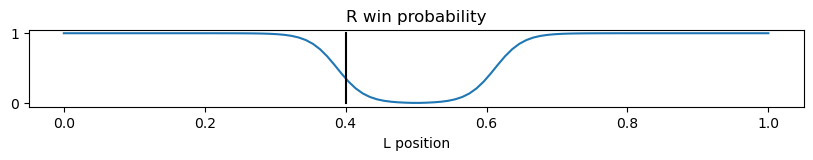

In [255]:
L_sample = np.linspace(0,1,100)
d_L = np.abs(L_sample-median_pos)
plt.figure(figsize=(10,1))
plt.plot(L_sample, sigmoid(s*(k_R-k_L-t*(d_R-d_L))))
plt.plot([R,R], [0,1], color="black")
plt.xlabel("L position")
plt.title("R win probability")
plt.ylim(-0.05,1.05)
plt.show()

So as $L$ moves too far away the probability goes to 1, but due to the extra canvassing by $L$, $R$ will start to look like it will lose before $L$ has even passed it.

The authors then consider the impact of activists joining a party, which is two-fold. Firstly, they increase the chance of the part winning by increasing $k$, and secondly, they get the benefit of having the party align closer to their own interests. This is modelled discretely in the paper (you are either in or out of the party), and being involved carries a cost of $b$. Membership means you get a vote on the policy platform. 

We can look at the benefit of joining a party, given the current positions. In the paper they find an interesting variable $r$, which always exists, and is the best policy platform for all $x>r$. Here I plot the utility of the Right party position (normalised from 0 to 1 to see them all), given Left (red line), and depending on where the preferred position $x$ is. The median person is assumed to sit at 0.0.

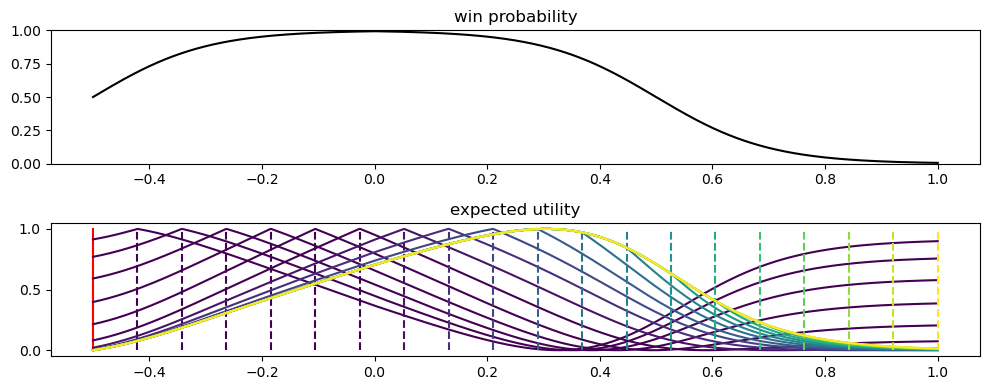

In [350]:
def get_win_prob(my_party, other_party, median_pos, s, t, k_party, k_other):
    d_other = np.abs(other_party-median_pos)
    d_party = np.abs(my_party-median_pos)
    win_prob = sigmoid(s*(k_party-k_other-t*(d_party-d_other)))
    return win_prob

def get_expected_utility(my_party, other_party, median_pos, my_pos, s, t, k_party, k_other):
    win_prob = get_win_prob(my_party, other_party, median_pos, s, t, k_party, k_other)
    d_other_party_to_me = np.abs(other_party-my_pos)
    d_party_to_me = np.abs(my_party-my_pos)
    expected_u = win_prob*(-t*d_party_to_me)+(1-win_prob)*(-t*d_other_party_to_me)
    return expected_u

L = -0.5
median_pos = 0.0
s = 0.1
t = 100.0
k_L = 0.0 # ignoring this for now
k_R = 0.0
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
R_samples = np.linspace(L,1,1000)
win_prob = np.array([get_win_prob(R, L, median_pos, s, t, k_R, k_L) for R in R_samples])
axs[0].plot(R_samples, win_prob, color="black")
axs[0].set_title("win probability")
axs[0].set_ylim(0,1)
axs[1].plot([L,L], [0,1], color="red")
axs[1].set_title("expected utility")
x_samples = np.linspace(L,1,20)[1:]
colors = plt.cm.viridis(x_samples)
for i, x in enumerate(x_samples):
    u = np.array([get_expected_utility(R, L, median_pos, x, s, t, k_R, k_L) for R in R_samples])
    u = u-np.min(u)
    u = u / np.max(u)
    axs[1].plot(R_samples, u, color=colors[i])
    axs[1].plot([x,x], [0,1], color=colors[i],linestyle="--")
plt.tight_layout()
plt.show()

For any individual with a preferred position above ~0.3 the peak of their utility curve is at 0.3. This is the point at which the benefits of increasing the policy are countered by a lower likelihood of winning. The utility if you win increases only linearly over R, but the chance of winning decreases as a sigmoid. The change in the utility is the product of the two. When the gradient of that fall below 0 it's time to stop. 

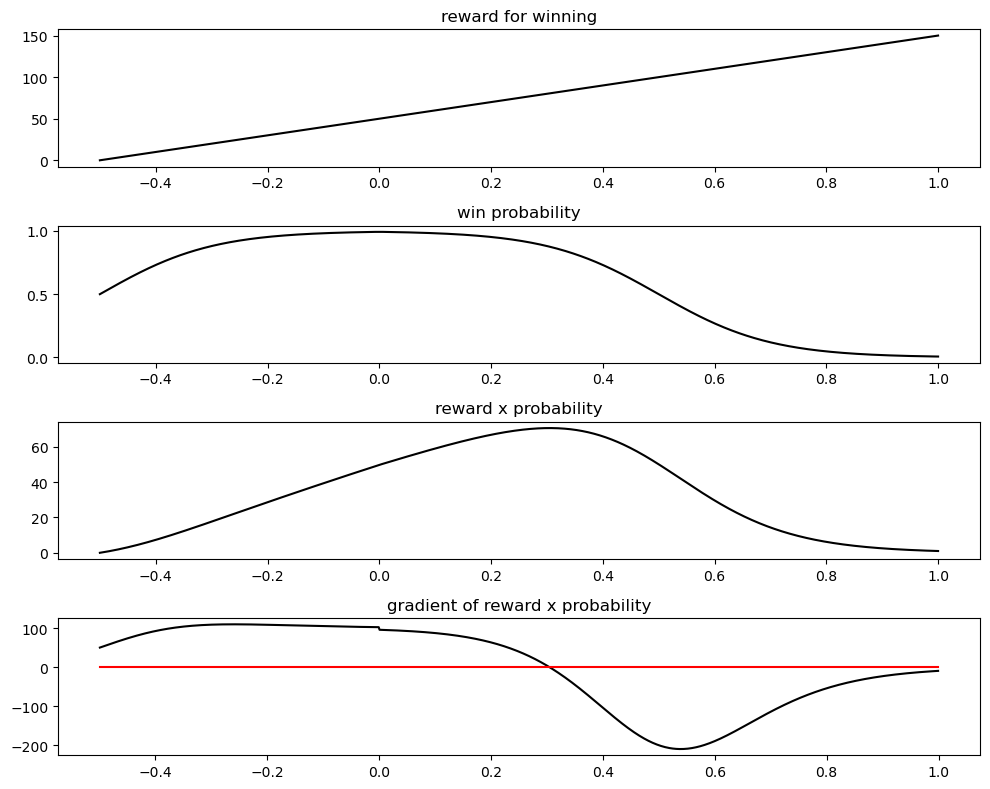

In [414]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Compute relative reward for winning
distances_to_1 = np.abs(1 - R_samples)
reward_of_winning = -t * distances_to_1
reward_of_winning -= np.min(reward_of_winning)
axs[0].plot(R_samples, reward_of_winning, color="black")
axs[0].set_title("reward for winning")

# Plot win probability
axs[1].plot(R_samples, win_prob, color="black")
axs[1].set_title("win probability")

# Plot combined function
final_reward = win_prob*reward_of_winning
axs[2].plot(R_samples, final_reward, color="black")
axs[2].set_title("reward x probability")

# Compute delta and midpoints
delta = R_samples[1] - R_samples[0]
mid_R = 0.5 * (R_samples[1:] + R_samples[:-1])

# Plot combined function gradient
fullGrad = (final_reward[1:] - final_reward[:-1]) / delta
axs[3].plot(mid_R, fullGrad, color="black")
axs[3].plot(mid_R, np.zeros(len(mid_R)), color="red")
axs[3].set_title("gradient of reward x probability")

plt.tight_layout()
plt.show()

Unsuprisingly when it comes to party dynamics the paper points out that if the majority of members of the party are beyond the point $r$, then $r$ will be the winning policy elected by the party (it is the most optimal, given the chances of winning, to a majority of members). On the other hand, if the median voter in the party is at $x<r$, then the party will converge to $x$. Essentially the best policy to run on is also the best policy to implement, according to the party voters. I.e., ignore the chances of winning. According to this model a political party will either elect the median position of it's voters or a more moderate position in order to be elected. It is very suprising that this is not a continuous thing! I would have thought a party would always consider it's likelihood in the full election, but this contradicts that. You either adjust for the extremism in your party or you don't. The paper goes on to talk about some key findings, the utility for candidates joining, more proofs, etc.